# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 5            
model_seed = 5           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6940 | Test Loss 0.6921 | accs Train 0.4775 Test 0.5383


Epoch 100/2000: Train Loss 0.4840 | Test Loss 0.4726 | accs Train 0.7550 Test 0.7720


Epoch 200/2000: Train Loss 0.0090 | Test Loss 0.0260 | accs Train 1.0000 Test 0.9918


Epoch 300/2000: Train Loss 0.0011 | Test Loss 0.0217 | accs Train 1.0000 Test 0.9935


Epoch 400/2000: Train Loss 0.0004 | Test Loss 0.0220 | accs Train 1.0000 Test 0.9940


Epoch 500/2000: Train Loss 0.0002 | Test Loss 0.0229 | accs Train 1.0000 Test 0.9940


Epoch 600/2000: Train Loss 0.0001 | Test Loss 0.0251 | accs Train 1.0000 Test 0.9940


Epoch 700/2000: Train Loss 0.0000 | Test Loss 0.0283 | accs Train 1.0000 Test 0.9942


Epoch 800/2000: Train Loss 0.0000 | Test Loss 0.0299 | accs Train 1.0000 Test 0.9942


Epoch 900/2000: Train Loss 0.0000 | Test Loss 0.0313 | accs Train 1.0000 Test 0.9940


Epoch 1000/2000: Train Loss 0.0000 | Test Loss 0.0323 | accs Train 1.0000 Test 0.9940


Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.0336 | accs Train 1.0000 Test 0.9940


Epoch 1200/2000: Train Loss 0.0000 | Test Loss 0.0348 | accs Train 1.0000 Test 0.9942


Epoch 1300/2000: Train Loss 0.0000 | Test Loss 0.0358 | accs Train 1.0000 Test 0.9945


Epoch 1400/2000: Train Loss 0.0000 | Test Loss 0.0368 | accs Train 1.0000 Test 0.9945


Epoch 1500/2000: Train Loss 0.0000 | Test Loss 0.0377 | accs Train 1.0000 Test 0.9945


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 0.0384 | accs Train 1.0000 Test 0.9945


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 0.0397 | accs Train 1.0000 Test 0.9945


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 0.0482 | accs Train 1.0000 Test 0.9945


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 0.0524 | accs Train 1.0000 Test 0.9945


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 0.0555 | accs Train 1.0000 Test 0.9945
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 0.6939 | Test Loss 0.6921 | accs Train 0.4780 Test 0.5407


Epoch 100/2000: Train Loss 0.4883 | Test Loss 0.4658 | accs Train 0.7171 Test 0.7465


Epoch 200/2000: Train Loss 0.0625 | Test Loss 0.0470 | accs Train 0.9780 Test 0.9895


Epoch 300/2000: Train Loss 0.0471 | Test Loss 0.0473 | accs Train 0.9780 Test 0.9885


Epoch 400/2000: Train Loss 0.0388 | Test Loss 0.0560 | accs Train 0.9829 Test 0.9855


Epoch 500/2000: Train Loss 0.0319 | Test Loss 0.0555 | accs Train 0.9878 Test 0.9855


Epoch 600/2000: Train Loss 0.0246 | Test Loss 0.0599 | accs Train 0.9951 Test 0.9860


Epoch 700/2000: Train Loss 0.0214 | Test Loss 0.0624 | accs Train 0.9927 Test 0.9865


Epoch 800/2000: Train Loss 0.0187 | Test Loss 0.0714 | accs Train 0.9902 Test 0.9828


Epoch 900/2000: Train Loss 0.0175 | Test Loss 0.0737 | accs Train 0.9927 Test 0.9825


Epoch 1000/2000: Train Loss 0.0148 | Test Loss 0.0890 | accs Train 0.9927 Test 0.9798


Epoch 1100/2000: Train Loss 0.0124 | Test Loss 0.0809 | accs Train 0.9927 Test 0.9825


Epoch 1200/2000: Train Loss 0.0115 | Test Loss 0.0872 | accs Train 0.9976 Test 0.9812


Epoch 1300/2000: Train Loss 0.0107 | Test Loss 0.0876 | accs Train 0.9927 Test 0.9815


Epoch 1400/2000: Train Loss 0.0089 | Test Loss 0.1005 | accs Train 0.9951 Test 0.9802


Epoch 1500/2000: Train Loss 0.0077 | Test Loss 0.1024 | accs Train 0.9976 Test 0.9800


Epoch 1600/2000: Train Loss 0.0069 | Test Loss 0.1114 | accs Train 0.9976 Test 0.9788


Epoch 1700/2000: Train Loss 0.0071 | Test Loss 0.1176 | accs Train 0.9976 Test 0.9782


Epoch 1800/2000: Train Loss 0.0060 | Test Loss 0.1228 | accs Train 0.9976 Test 0.9765


Epoch 1900/2000: Train Loss 0.0112 | Test Loss 0.1099 | accs Train 0.9951 Test 0.9808


Epoch 2000/2000: Train Loss 0.0182 | Test Loss 0.0820 | accs Train 0.9951 Test 0.9830
Completed training with 10 additional samples of poison
Epoch 1/2000: Train Loss 0.6939 | Test Loss 0.6921 | accs Train 0.4786 Test 0.5400


Epoch 100/2000: Train Loss 0.4926 | Test Loss 0.4792 | accs Train 0.8000 Test 0.8127


Epoch 200/2000: Train Loss 0.1155 | Test Loss 0.0854 | accs Train 0.9619 Test 0.9815


Epoch 300/2000: Train Loss 0.0897 | Test Loss 0.0774 | accs Train 0.9619 Test 0.9810


Epoch 400/2000: Train Loss 0.0768 | Test Loss 0.0767 | accs Train 0.9738 Test 0.9828


Epoch 500/2000: Train Loss 0.0673 | Test Loss 0.0930 | accs Train 0.9762 Test 0.9790


Epoch 600/2000: Train Loss 0.0602 | Test Loss 0.1148 | accs Train 0.9762 Test 0.9732


Epoch 700/2000: Train Loss 0.0565 | Test Loss 0.1703 | accs Train 0.9833 Test 0.9553


Epoch 800/2000: Train Loss 0.0517 | Test Loss 0.1319 | accs Train 0.9810 Test 0.9715


Epoch 900/2000: Train Loss 0.0486 | Test Loss 0.1461 | accs Train 0.9810 Test 0.9683


Epoch 1000/2000: Train Loss 0.0460 | Test Loss 0.1605 | accs Train 0.9810 Test 0.9650


Epoch 1100/2000: Train Loss 0.0441 | Test Loss 0.1578 | accs Train 0.9857 Test 0.9637


Epoch 1200/2000: Train Loss 0.0420 | Test Loss 0.1732 | accs Train 0.9857 Test 0.9597


Epoch 1300/2000: Train Loss 0.0389 | Test Loss 0.1926 | accs Train 0.9905 Test 0.9583


Epoch 1400/2000: Train Loss 0.0367 | Test Loss 0.1958 | accs Train 0.9881 Test 0.9585


Epoch 1500/2000: Train Loss 0.0374 | Test Loss 0.1919 | accs Train 0.9833 Test 0.9607


Epoch 1600/2000: Train Loss 0.0344 | Test Loss 0.2140 | accs Train 0.9881 Test 0.9577


Epoch 1700/2000: Train Loss 0.0332 | Test Loss 0.2250 | accs Train 0.9905 Test 0.9543


Epoch 1800/2000: Train Loss 0.0317 | Test Loss 0.2569 | accs Train 0.9881 Test 0.9535


Epoch 1900/2000: Train Loss 0.1613 | Test Loss 0.4272 | accs Train 0.9738 Test 0.9340


Epoch 2000/2000: Train Loss 0.0397 | Test Loss 0.2501 | accs Train 0.9833 Test 0.9613
Completed training with 20 additional samples of poison
Epoch 1/2000: Train Loss 0.6936 | Test Loss 0.6921 | accs Train 0.4867 Test 0.5370


Epoch 100/2000: Train Loss 0.5215 | Test Loss 0.4636 | accs Train 0.7978 Test 0.8455


Epoch 200/2000: Train Loss 0.2539 | Test Loss 0.1350 | accs Train 0.8956 Test 0.9778


Epoch 300/2000: Train Loss 0.2254 | Test Loss 0.1332 | accs Train 0.9000 Test 0.9718


Epoch 400/2000: Train Loss 0.2109 | Test Loss 0.1494 | accs Train 0.9067 Test 0.9565


Epoch 500/2000: Train Loss 0.1936 | Test Loss 0.1646 | accs Train 0.9200 Test 0.9475


Epoch 600/2000: Train Loss 0.1765 | Test Loss 0.1756 | accs Train 0.9378 Test 0.9455


Epoch 700/2000: Train Loss 0.1712 | Test Loss 0.1978 | accs Train 0.9222 Test 0.9397


Epoch 800/2000: Train Loss 0.1546 | Test Loss 0.2241 | accs Train 0.9400 Test 0.9300


Epoch 900/2000: Train Loss 0.1481 | Test Loss 0.2506 | accs Train 0.9333 Test 0.9207


Epoch 1000/2000: Train Loss 0.1413 | Test Loss 0.2505 | accs Train 0.9467 Test 0.9303


Epoch 1100/2000: Train Loss 0.1341 | Test Loss 0.2651 | accs Train 0.9444 Test 0.9310


Epoch 1200/2000: Train Loss 0.1288 | Test Loss 0.2957 | accs Train 0.9356 Test 0.9185


Epoch 1300/2000: Train Loss 0.1263 | Test Loss 0.3127 | accs Train 0.9422 Test 0.9200


Epoch 1400/2000: Train Loss 0.1209 | Test Loss 0.3185 | accs Train 0.9422 Test 0.9195


Epoch 1500/2000: Train Loss 0.1156 | Test Loss 0.3096 | accs Train 0.9533 Test 0.9327


Epoch 1600/2000: Train Loss 0.1107 | Test Loss 0.3560 | accs Train 0.9600 Test 0.9195


Epoch 1700/2000: Train Loss 0.1078 | Test Loss 0.3420 | accs Train 0.9578 Test 0.9235


Epoch 1800/2000: Train Loss 0.1040 | Test Loss 0.3647 | accs Train 0.9600 Test 0.9243


Epoch 1900/2000: Train Loss 0.1026 | Test Loss 0.3639 | accs Train 0.9600 Test 0.9245


Epoch 2000/2000: Train Loss 0.1085 | Test Loss 0.3592 | accs Train 0.9511 Test 0.9270
Completed training with 50 additional samples of poison
Epoch 1/2000: Train Loss 0.6936 | Test Loss 0.6922 | accs Train 0.4780 Test 0.5365


Epoch 100/2000: Train Loss 0.5735 | Test Loss 0.5134 | accs Train 0.7460 Test 0.8150


Epoch 200/2000: Train Loss 0.4193 | Test Loss 0.2869 | accs Train 0.8140 Test 0.9345


Epoch 300/2000: Train Loss 0.3783 | Test Loss 0.2746 | accs Train 0.8280 Test 0.9183


Epoch 400/2000: Train Loss 0.3542 | Test Loss 0.2635 | accs Train 0.8280 Test 0.9170


Epoch 500/2000: Train Loss 0.3324 | Test Loss 0.2967 | accs Train 0.8460 Test 0.8950


Epoch 600/2000: Train Loss 0.3140 | Test Loss 0.3002 | accs Train 0.8560 Test 0.8955


Epoch 700/2000: Train Loss 0.2991 | Test Loss 0.3031 | accs Train 0.8700 Test 0.8895


Epoch 800/2000: Train Loss 0.2826 | Test Loss 0.3318 | accs Train 0.8800 Test 0.8725


Epoch 900/2000: Train Loss 0.2695 | Test Loss 0.3237 | accs Train 0.8860 Test 0.8798


Epoch 1000/2000: Train Loss 0.2614 | Test Loss 0.3449 | accs Train 0.8740 Test 0.8652


Epoch 1100/2000: Train Loss 0.2586 | Test Loss 0.3738 | accs Train 0.8780 Test 0.8528


Epoch 1200/2000: Train Loss 0.2384 | Test Loss 0.4125 | accs Train 0.8940 Test 0.8417


Epoch 1300/2000: Train Loss 0.2409 | Test Loss 0.3991 | accs Train 0.8880 Test 0.8588


Epoch 1400/2000: Train Loss 0.2273 | Test Loss 0.4316 | accs Train 0.8880 Test 0.8495


Epoch 1500/2000: Train Loss 0.2247 | Test Loss 0.4566 | accs Train 0.9000 Test 0.8417


Epoch 1600/2000: Train Loss 0.2167 | Test Loss 0.4642 | accs Train 0.9080 Test 0.8525


Epoch 1700/2000: Train Loss 0.2166 | Test Loss 0.4445 | accs Train 0.8960 Test 0.8522


Epoch 1800/2000: Train Loss 0.2083 | Test Loss 0.5731 | accs Train 0.9020 Test 0.8007


Epoch 1900/2000: Train Loss 0.2095 | Test Loss 0.4934 | accs Train 0.9060 Test 0.8480


Epoch 2000/2000: Train Loss 0.1961 | Test Loss 0.5256 | accs Train 0.9160 Test 0.8340
Completed training with 100 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.0555 | accs: 0.9945
  10 samples | Test Loss: 0.0820 | accs: 0.9830
  20 samples | Test Loss: 0.2501 | accs: 0.9613
  50 samples | Test Loss: 0.3592 | accs: 0.9270
 100 samples | Test Loss: 0.5256 | accs: 0.8340

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0088 | accs: 0.9975
 Model   20 | Train Loss: 0.0180 | accs: 0.9950
 Model   50 | Train Loss: 0.0466 | accs: 0.9875
 Model  100 | Train Loss: 0.1101 | accs: 0.9725

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.4653 | accs: 0.9756
 Model   10 | Train Loss: 0.0182 | accs: 0.9927
 Model   20 | Train Loss: 0.0305 | accs: 0.9902
 Model   50 | Train Loss: 0.0680 | accs: 0.9780
 Model  100 | Train Loss: 0.1215 | accs: 0.9659

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.7976 | accs: 0.9548
 Model   10 | Train Los

### Model + Data Specific Verification

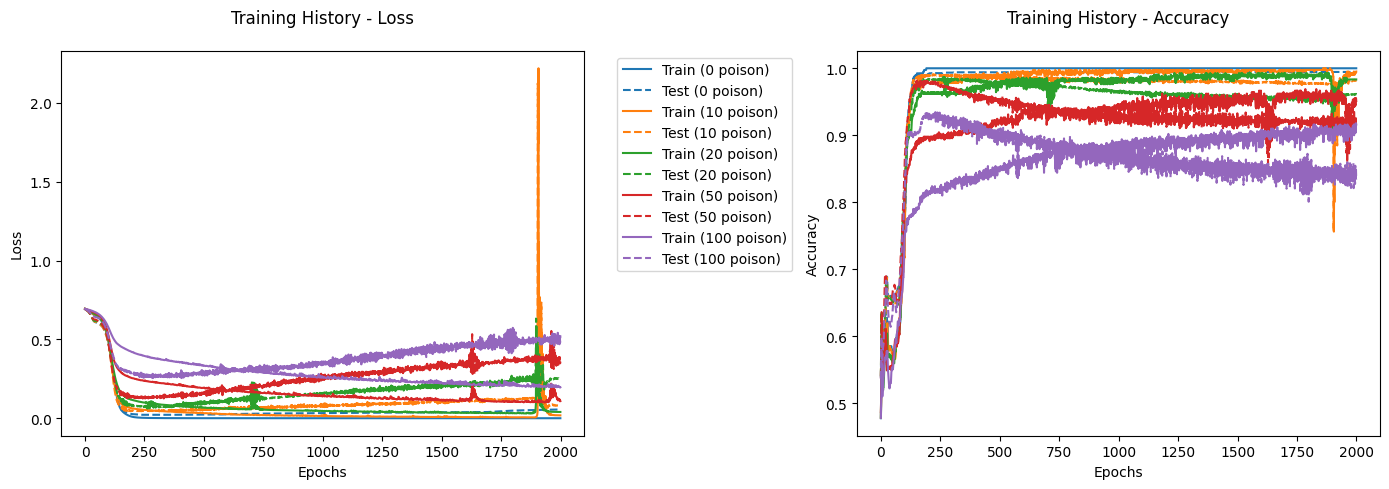

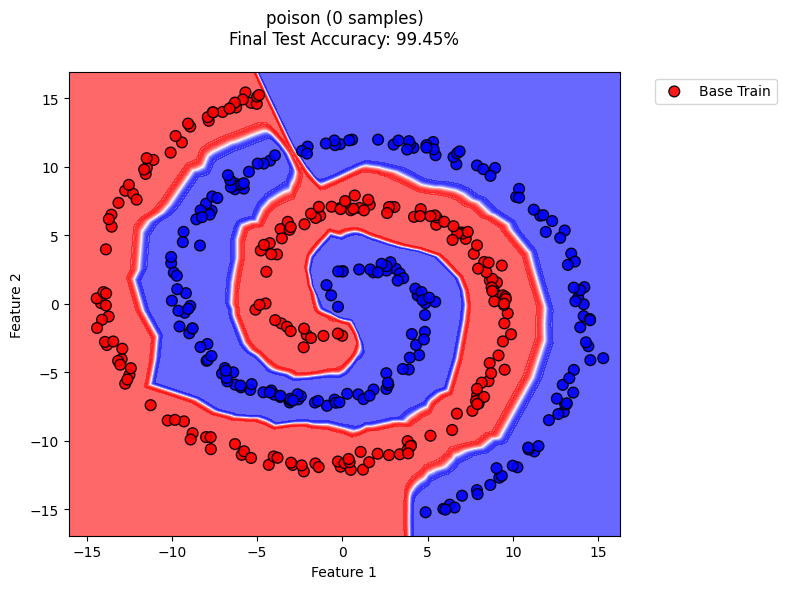

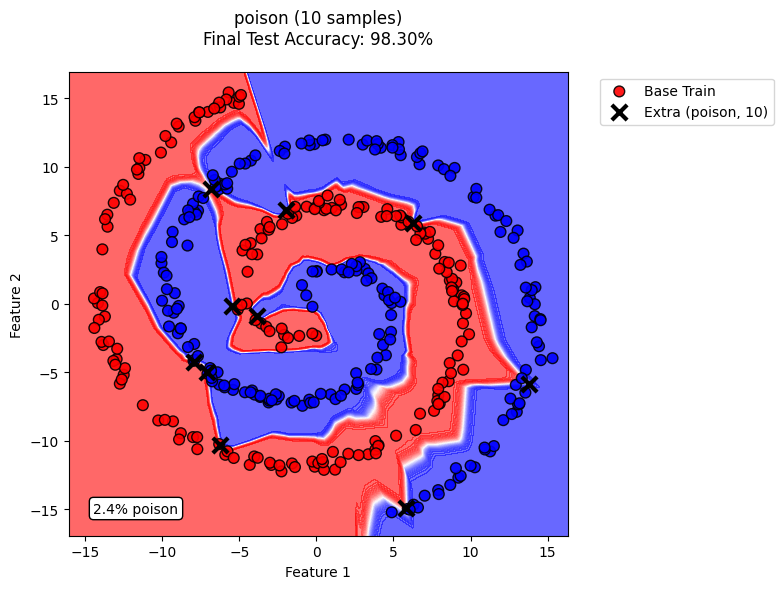

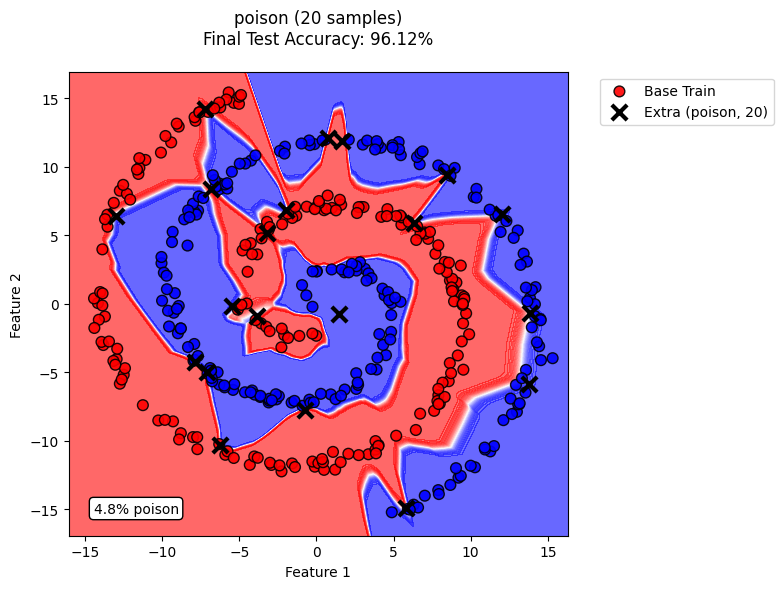

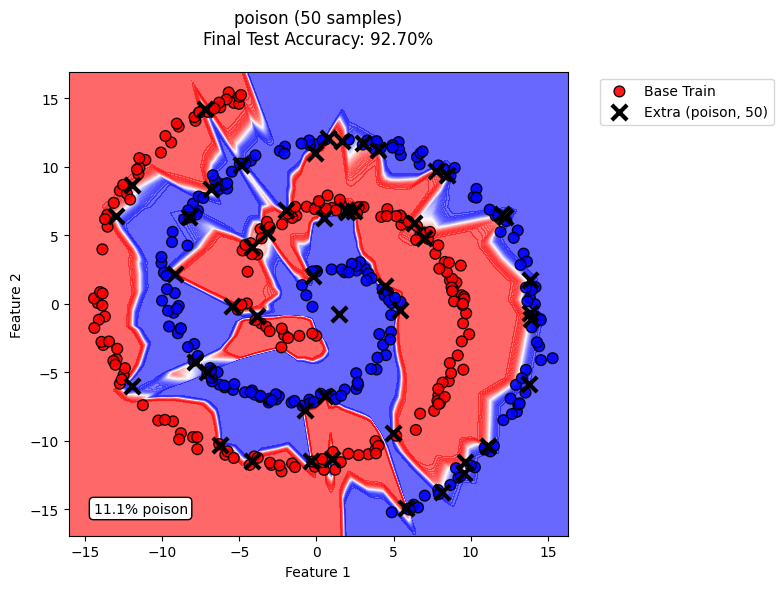

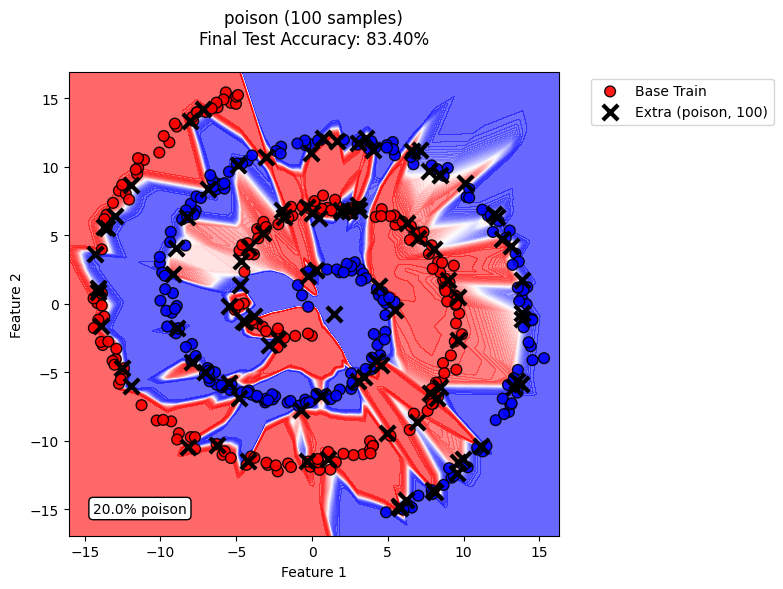

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
